In [1]:
import glob
import os

import torch
import numpy as np
from captum.attr import Saliency
from matplotlib.colors import LinearSegmentedColormap

from networks import resnext50_32x4d, resnet18, regularize_path_weights
import torch.nn as nn
from train_test import test
from data_loaders import *
from train_TCGA_test_QHCGorQYFY import path_cleaning,max_path_cleaning

import albumentations as A
from albumentations.pytorch import ToTensorV2
from PIL import Image
import matplotlib.pyplot as plt

import seaborn as sns
from matplotlib.colors import ListedColormap
from matplotlib import colors
from scipy.ndimage.filters import gaussian_filter
from matplotlib.colors import Normalize

ResNet(
  (conv1): Conv2d(8, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 128, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
      (bn2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(128, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1

In [5]:
def get_Atrrmap(file_path):
    PATH = 'checkpoint path'
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    model = resnext50_32x4d()
    checkpoint = torch.load(PATH)
    model.load_state_dict(checkpoint['model_state_dict'])
    model = nn.DataParallel(model, device_ids=[0, 1, 2, 3])
    model = model.to(device)
    model.eval()

    seg_filepaths = [file_path]
    print(len(seg_filepaths))
    for seg_filepath in seg_filepaths:

        input_npy = np.load(seg_filepath)# Create an input tensor image for your model..
        train_transform = A.Compose(
            [   
                A.Resize(512, 512),
                # A.RandomRotate90(p = 1),
                A.Normalize(mean=(0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5), std=(0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5)),
                ToTensorV2(),
            ]
        )
        # Augment an image
        transformed = train_transform(image=input_npy)
        transformed_image = transformed["image"]
        input_tensor = transformed_image.unsqueeze(0).float()

        saliency = Saliency(model)
        Attrmap = saliency.attribute(input_tensor, target=None,abs=False)
    
    return Attrmap

In [13]:
def vis(seg_filepath,attributions_ig, save_path):
    prob_matrix = np.load(seg_filepath)
    multi_classes = np.zeros((prob_matrix.shape[0],prob_matrix.shape[1]))

    for i in range(prob_matrix.shape[0]):

        for j in range(prob_matrix.shape[1]):
            multi_classes[i][j] = np.argmax(prob_matrix[i,j,:])

            if prob_matrix[i,j,0] == 0 and multi_classes[i][j] == 0:
                multi_classes[i][j] = 1

    #get attribute
    a = attributions_ig.detach().numpy()
    a = np.squeeze(a)
    a = abs(a).sum(axis = 0)
    a = a/np.percentile(a.flatten(), 95)
    a = gaussian_filter(a, sigma=1)
 

    plt.figure(figsize=(8,8))
    plt.xticks(())
    plt.yticks(())
    plt.gca().set_axis_off()
    plt.subplots_adjust(top = 1, bottom = 0, right = 1, left = 0, 
                hspace = 0, wspace = 0)
    plt.margins(0,0)
    plt.gca().xaxis.set_major_locator(plt.NullLocator())
    plt.gca().yaxis.set_major_locator(plt.NullLocator())
    plt.axis('off')
    attri_map = np.squeeze(a)

    b = ["#FF0000", "#FFFFFF", "#9400D3", "#808080", "#FF69B4", "#98FB98","#00BFFF","#FFA500"]
    flatui = b
    sns.set_palette(flatui)
    segmap = multi_classes
    cmap = ListedColormap(flatui)
 
    plt.imshow(segmap, cmap = cmap, interpolation = 'nearest')
    xmin, xmax = plt.xlim()
    ymin, ymax = plt.ylim()
    # alphas = Normalize(0, 1, clip=True)(np.abs(attri_map))
    alphas = np.clip(attri_map, .7, 1)
    plt.imshow(attri_map,cmap='gray',alpha=1-alphas,extent=(xmin,xmax,ymin,ymax))
 
    # img_save_path = save_path + '/merge'
    # if os.path.exists(img_save_path) ==  False:
    #     os.makedirs(img_save_path)

    # plt.savefig(img_save_path + '/{}.png'.format(seg_filepath.split('/')[-1][:15]), bbox_inches = 'tight', pad_inches = 0)#TCGA
    # plt.clf()
    # plt.close('all')
    
    return None

In [8]:
file_path = 'heatmaps .npy path'
attrmap = get_Atrrmap(file_path)

1


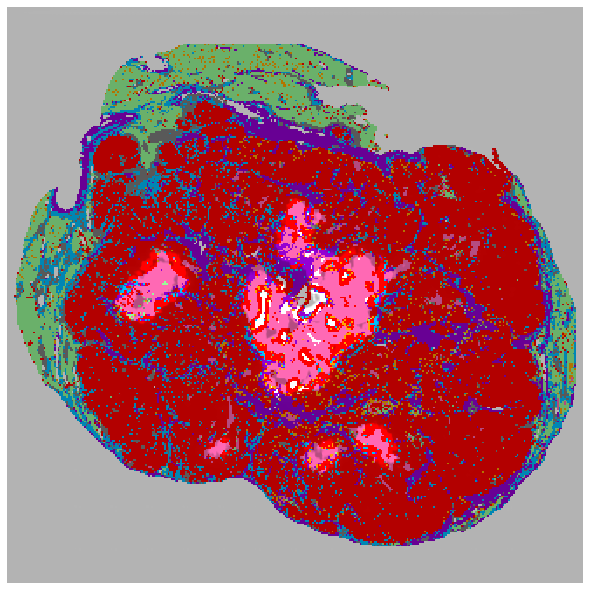

In [14]:
vis(file_path, attrmap, '')